# Introducción
El proceso que he seguido para separar letras a partir de las que genero un dataset.

Este proceso está automatizado en el script `src/genera_captchas_dataset.py`.

In [1]:
import re
import os
import cv2
import pytesseract
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import src.extrae_letras_toolbox as tb

print("Setup completado!")

Setup completado!


In [2]:
def get_image(file_path):
    return cv2.imread(file_path)

def get_captcha_text_from_filename(file_path):
    filename = os.path.basename(file_path)
    return re.sub("\.png$", "", filename)

def show(image):
    plt.imshow(image, cmap='Greys')
    plt.show()

def image_to_bnw(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def smoothing_median_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.medianBlur(image.copy(), i)
    return smoothed_image

def image_thresholding(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,91,2)

def get_contours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def get_area(width, height):
    return width * height

def get_regions(contours):
    regions = []
    
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # Asumo que si el área de un rectángulo es menor de 500px² se trata de una agrupación de puntos en vez de una letra
        if get_area(w, h) > 500:
            regions.append((x, y, w, h))

    return regions

def get_sorted_regions_by_area_size(regions):
    '''
    recibe:   Una lista con regiones.
              Cada región es una tupla con cuatro valores:
              - coordenada x
              - coordenada y
              - altura
              - anchura
    devuelve: la lista ordenada de región con mayor área a región con menor área 
    '''
    # Los índices 2 y 3 corresponden a altura y anchura
    return sorted(regions, key=lambda x: get_area(x[2], x[3]), reverse = True)

def get_largest_region_by_area_size(regions):
    return get_sorted_regions_by_area_size(regions)[0]

def divide_region_by_width(region):
    '''
    recibe: una tupla con cuatro valores:
            - coordenada x
            - coordenada y
            - anchura
            - altura

    devuelve: dos regiones resultado de la división de la región anterior por anchura.
    '''
    x, y, w, h = region
    half_width = w // 2
    
    result = []
    result.append((x, y, half_width, h))
    result.append((x + half_width, y, half_width, h))
    
    return result

def paint_regions(image, regions):
    for region in regions:
        x, y, w, h = region
        cv2.rectangle(image, (x,y), (x+w,y+h), (255,0,0),1)
    plt.imshow(image)

def get_sorted_regions_by_coord_x(regions):
    return sorted(regions, key=lambda r: r[0])

def save_letter_image(image, letter, output_folder = 'input/letter_dataset/training/'):
    save_path = os.path.join(output_folder, letter)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    filename = letter + "_" + dt.datetime.now().strftime("%y%m%d_%H%M%S%fZ")

    file_path = os.path.join(save_path, f"{filename}.png")
    cv2.imwrite(file_path, image)


## Cargo la imagen del captcha

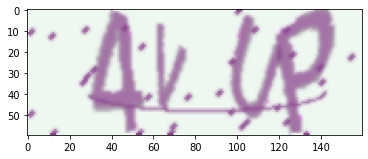

El texto que oculta es:  4VUP


In [3]:
captcha_image_filename = 'analisis/4VUP.png'

image = tb.get_image(captcha_image_filename)

show(image)
print("El texto que oculta es: ", get_captcha_text_from_filename(captcha_image_filename))

**Nota** 

Esta otra imagen no la lee bien. Tengo que probar otros settings a ver si puedo adaptarlo a este tipo de imágenes:

`captcha_image_filename = 'analisis/R2G8.png'`

## Pasar la imagen a Blanco y Negro

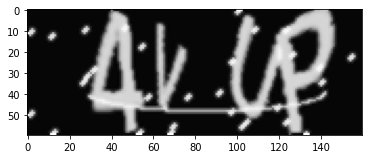

In [4]:
image_bnw = tb.image_to_bnw(image.copy())

show(image_bnw)

## [OBSOLETO] Smoothing
Al principio usé *smoothing* para intentar quitar ruido del captcha y aislar los caracteres lo mejor posible.

Probé cuatro métodos:

### Homogeneous Blur

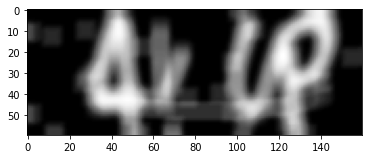

In [5]:
def smoothing_homogeneous_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.blur(image.copy(), (i, i))
    return smoothed_image
        
smoothed_image = smoothing_homogeneous_blur(image_bnw)
show(smoothed_image)

### Gaussian Blur

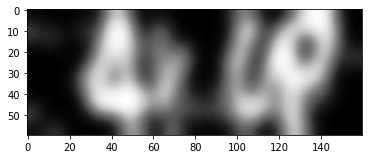

In [6]:
def smoothing_gaussian_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.GaussianBlur(image.copy(), (i, i), 0)
    return smoothed_image
        
smoothed_image = smoothing_gaussian_blur(image_bnw, max_kernel_length = 31)
show(smoothed_image)

### Bilateral Filter

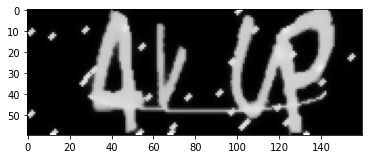

In [7]:
def smoothing_bilateral_filter(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.bilateralFilter(image.copy(), i, i * 2, i / 2)
    return smoothed_image
        
smoothed_image = smoothing_bilateral_filter(image_bnw)
show(smoothed_image)

### Median Blur

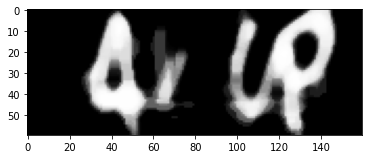

In [8]:
def smoothing_median_blur(image, max_kernel_length = 10):
    for i in range(1, max_kernel_length, 2):
        smoothed_image = cv2.medianBlur(image.copy(), i)
    return smoothed_image
        
smoothed_image = smoothing_median_blur(image_bnw)
show(smoothed_image)

### Conclusión
Después de aplicar los cuatro métodos el que mejor resultado me dió fué **Median Blur**. 

**Nota** ¿Se puede aplicar primero un método, después otro, etc. para obtener mejor resultado?

## Dilation
Paso 1.

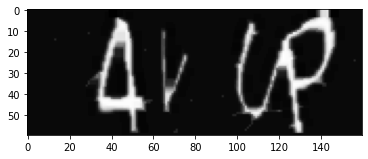

In [9]:
kernel = np.ones((2,2), np.uint8)
dilation = cv2.dilate(image_bnw, kernel, iterations=3)

show(dilation)

## Erosion

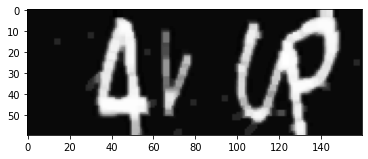

In [10]:
kernel = np.ones((2,2), np.uint8)
erosion = cv2.erode(dilation, kernel, iterations=2)

show(erosion)

## Denoise

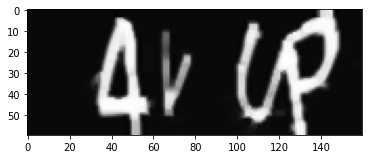

In [11]:
denoise = cv2.fastNlMeansDenoising(erosion, 21, 7)

show(denoise)

## Adaptative Thresholding
Tras haber tratado la imagen le pasamos un adaptative thresholding para definir los caracteres. 

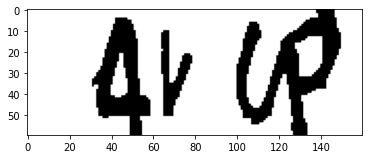

In [12]:
thresholded_image = image_thresholding(denoise)

show(thresholded_image)

# Probando el OCR Tesseract
Pruebo cómo distingue este OCR las imágenes.

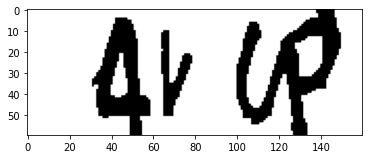

Resultado:  4



In [13]:
# Las opciones que he usado para Tesseract
# - psm 11 (page segmentation modes). Selecciono 11: trata la imagen como si fuese una única línea de texto. 
# - oem 1 (OCR engine mode). Selecciono 1: Neural nets LSTM engine only.
# - tessedit_char_whitelist: ignora los caracteres que no estén en esta lista.

custom_config = '--psm 11 --oem 1 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
ocr_result = pytesseract.image_to_string(thresholded_image, config=custom_config)

show(thresholded_image)

print("Resultado: ", ocr_result)

## Conclusión
Parece que el OCR no funciona muy bien.

# Juntándolo todo
Aplico las transformaciones para aislar y extraer las letras que formarán el set de datos de entrenamiento.

Estas transformaciones las he extraido al módulo: `src.extrae_letras_toolbox`

## Encuentro el contorno de las letras

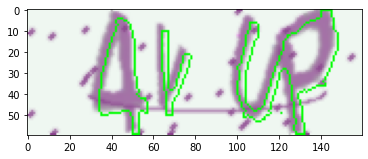

In [14]:
test_image = image.copy()

test_image_bnw = tb.image_to_bnw(image.copy())
dilation_image = tb.apply_dilation(test_image_bnw)
erosion_image = tb.apply_erosion(dilation_image)
denoise_image = tb.apply_denoise(erosion_image)
thresholded_image = tb.apply_thresholding(denoise_image)

contours = tb.get_contours(thresholded_image)

# Muestro la imagen con los contornos:
cv2.drawContours(test_image, contours, -1, (0,255,0), 1)
show(test_image)


## Busco la región de cada letra
Una región es el rectángulo que envuelve cada letra.

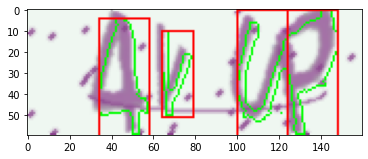

In [15]:
# Una región es el rectángulo que envuelve cada letra
regions = tb.get_regions(contours)

# Estamos tratando captchas de 4 letras.
# Si recibimos menos de 4 regiones seguramente se han juntado varias letras en una sola región que hay que dividir.
while len(regions) < 4:
    largest_region = tb.get_largest_region_by_area_size(regions)
    new_regions = tb.divide_region_by_width(largest_region)
    regions += new_regions
    regions.remove(largest_region)

# Muestro las regiones sobre la imagen:
paint_regions(test_image, regions)

# El último paso es guardar una imagen de cada región
Cada región representa una letra o número se guardará en un directorio diferente. Por ejemplo:
- `input/letter_dataset/training/A/` para todas las letras "A"
- `input/letter_dataset/training/B/` para todas las letras "B"
- `input/letter_dataset/training/C/` para todas las letras "C"
- etc.

Esos directorios son los que forman el conjunto de datos de entrenamiento para los algoritmos de machine learning.

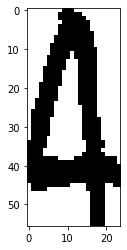

Imagen para la letra 4 guardada.


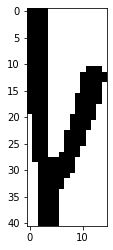

Imagen para la letra V guardada.


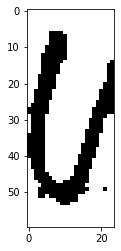

Imagen para la letra U guardada.


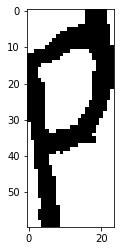

Imagen para la letra P guardada.


In [16]:
for region, letter in zip(get_sorted_regions_by_coord_x(regions), get_captcha_text_from_filename(captcha_image_filename)):
    x, y, w, h = region
    
    letter_image = thresholded_image[y:y + h, x:x + w]
    
    show(letter_image)
    
    # Este paso que comento es el que guardaría la imagen en disco:
    #tb.save_letter_image(letter_image, letter)

    print(f"Imagen para la letra {letter} guardada.")